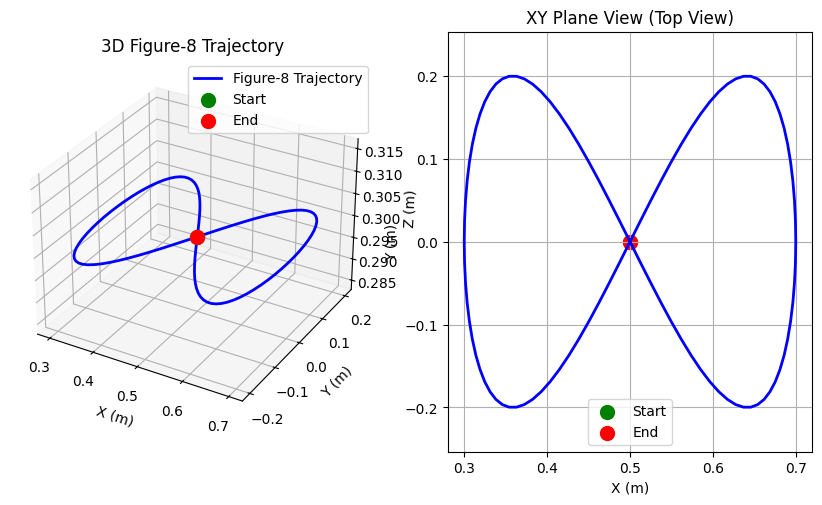

In [ ]:
# Create an ideal path for comparison with the implemented trajectory 
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

path = os.path.abspath('/media/kai/Kai_Backup/Master_Study/Master_Thesis/Master_Study_Master_Thesis/fr3_mujoco_ws/src/franka_mujoco_controller/franka_mujoco_controller')
sys.path.append(path)

from TrajectoryGenerator import TrajectoryGenerator

# Create instance without ROS2 (just for using the trajectory function)
traj_gen = TrajectoryGenerator.__new__(TrajectoryGenerator)  # Create without calling __init__

# Generate trajectory data
time_points = np.arange(0, 10.1, 0.1)  # 0 to 10 seconds, 0.1s intervals
positions = []

for t in time_points:
    pos = traj_gen.generate_figure8_trajectory(t)
    positions.append(pos)

positions = np.array(positions)

# Extract X, Y, Z coordinates
x_coords = positions[:, 0]
y_coords = positions[:, 1] 
z_coords = positions[:, 2]

# Create comprehensive plots
fig = plt.figure(figsize=(16, 12))

## 3D Trajectory Plot
ax1 = fig.add_subplot(2, 3, 1, projection='3d') ## 2 * 3 grid, first subplot is 3D
ax1.plot(x_coords, y_coords, z_coords, 'b-', linewidth=2, label='Figure-8 Trajectory')
ax1.scatter(x_coords[0], y_coords[0], z_coords[0], color='green', s=100, label='Start')
ax1.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color='red', s=100, label='End')

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('3D Figure-8 Trajectory')
ax1.legend()
ax1.grid(True)

# XY Plane View (Top view)
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(x_coords, y_coords, 'b-', linewidth=2)
ax2.scatter(x_coords[0], y_coords[0], color='green', s=100, label='Start')
ax2.scatter(x_coords[-1], y_coords[-1], color='red', s=100, label='End')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('XY Plane View (Top View)')
ax2.grid(True)
ax2.axis('equal')
ax2.legend()

# Save trajectory data for later comparison
trajectory_data = {
    'time': time_points,
    'positions': positions,
}

Reading bag...
Available topics: ['/local_robot/ee_pose']
Extracted 92 poses


/tmp/ipykernel_175715/1556465057.py:23: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


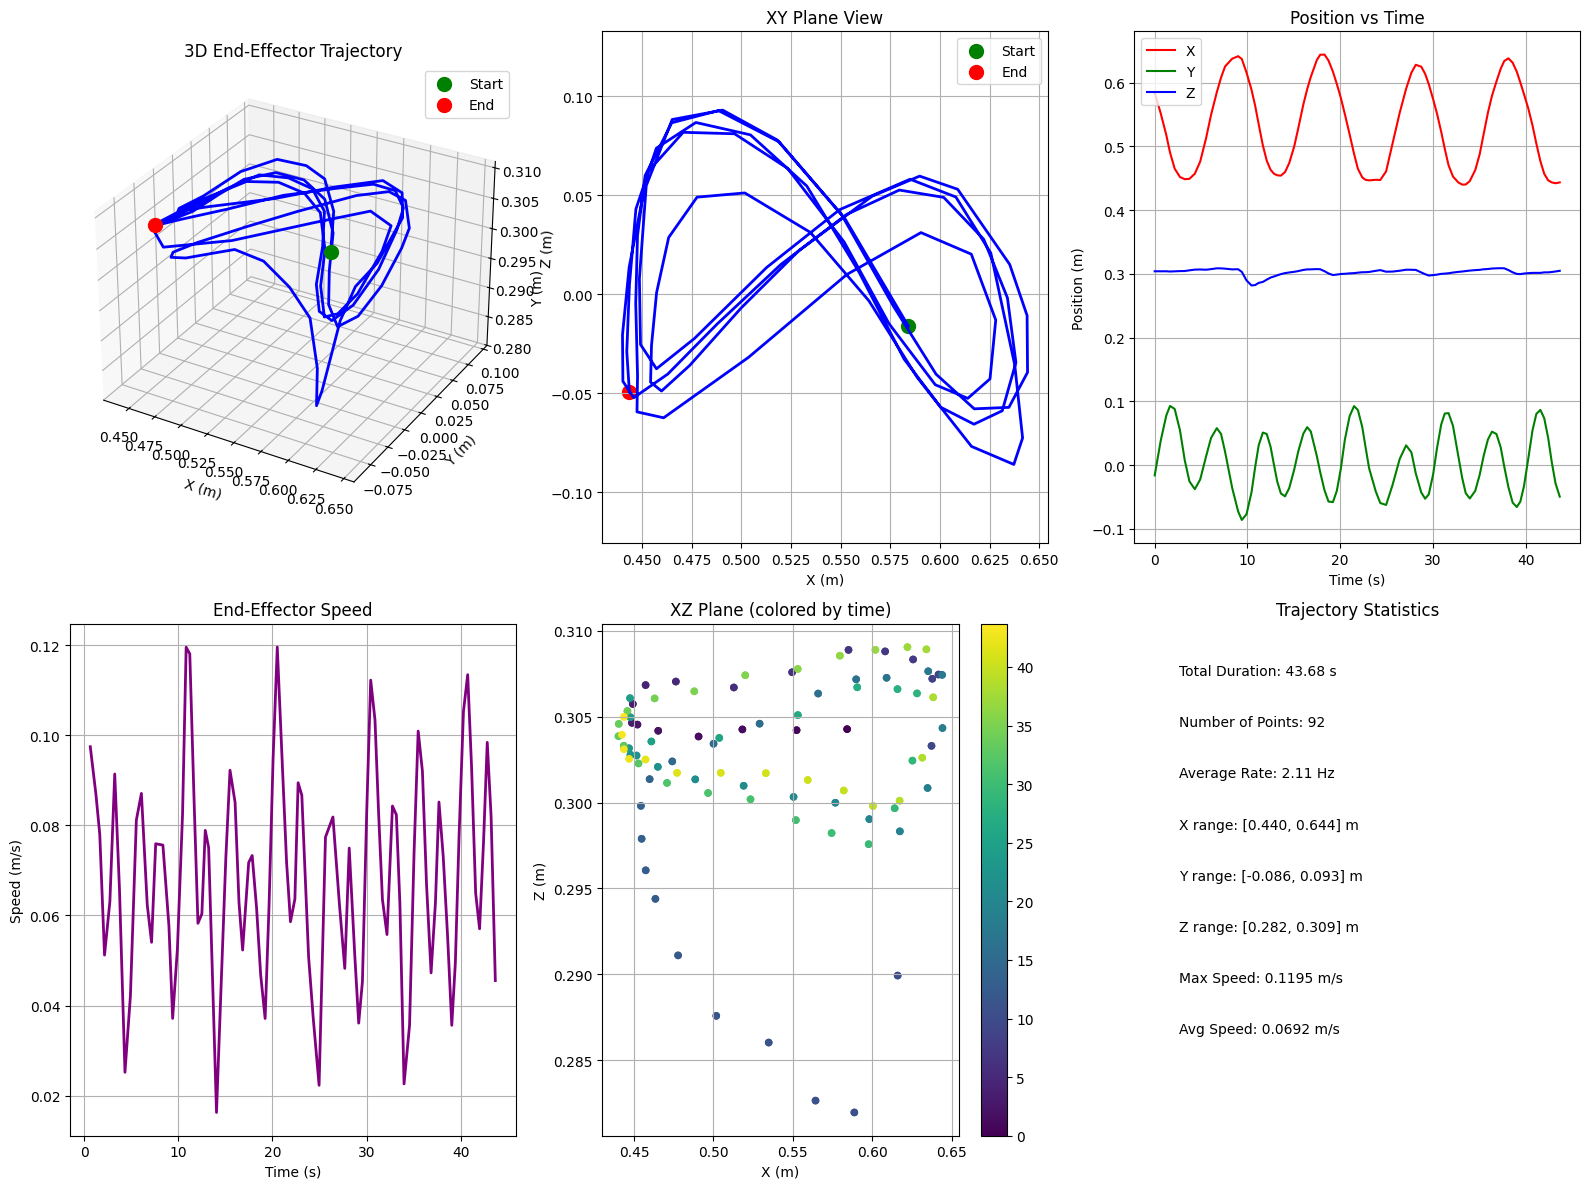


=== ANALYSIS COMPLETE ===
Trajectory plot saved as 'trajectory_analysis.png'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr

os.chdir('/media/kai/Kai_Backup/Master_Study/Master_Thesis/Master_Study_Master_Thesis/fr3_mujoco_ws')
bag_path = "trajectory_data"  # Path to the recorded bag file

poses = []

with Reader(bag_path) as reader:
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/local_robot/ee_pose':
            msg = deserialize_cdr(rawdata, connection.msgtype)
            
            # Extract pose data
            poses.append([
                msg.pose.position.x,
                msg.pose.position.y,
                msg.pose.position.z,
                timestamp * 1e-9 
            ])

poses = np.array(poses)

def plot_trajectory(poses):
    """Create comprehensive trajectory plots."""
    if poses is None or len(poses) == 0:
        print("No data to plot!")
        return
    
    # Normalize time to start from 0
    poses[:, 3] = poses[:, 3] - poses[0, 3]
    
    fig = plt.figure(figsize=(16, 12))
    
    # 3D trajectory
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot(poses[:, 0], poses[:, 1], poses[:, 2], 'b-', linewidth=2)
    ax1.scatter(poses[0, 0], poses[0, 1], poses[0, 2], c='green', s=100, label='Start')
    ax1.scatter(poses[-1, 0], poses[-1, 1], poses[-1, 2], c='red', s=100, label='End')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.legend()
    ax1.set_title('3D End-Effector Trajectory')
    
    # XY plane view (should show figure-8 if that's what you recorded)
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(poses[:, 0], poses[:, 1], 'b-', linewidth=2)
    ax2.scatter(poses[0, 0], poses[0, 1], c='green', s=100, label='Start')
    ax2.scatter(poses[-1, 0], poses[-1, 1], c='red', s=100, label='End')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('XY Plane View')
    ax2.legend()
    ax2.grid(True)
    ax2.axis('equal')
    
    # Position vs time
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.plot(poses[:, 3], poses[:, 0], 'r-', label='X')
    ax3.plot(poses[:, 3], poses[:, 1], 'g-', label='Y')
    ax3.plot(poses[:, 3], poses[:, 2], 'b-', label='Z')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Position (m)')
    ax3.set_title('Position vs Time')
    ax3.legend()
    ax3.grid(True)
    
    # Velocity analysis
    ax4 = fig.add_subplot(2, 3, 4)
    dt = np.diff(poses[:, 3])
    velocity = np.diff(poses[:, :3], axis=0) / dt.reshape(-1, 1)
    speed = np.linalg.norm(velocity, axis=1)
    ax4.plot(poses[1:, 3], speed, 'purple', linewidth=2)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Speed (m/s)')
    ax4.set_title('End-Effector Speed')
    ax4.grid(True)
    
    # Workspace analysis
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.scatter(poses[:, 0], poses[:, 2], c=poses[:, 3], cmap='viridis', s=20)
    ax5.set_xlabel('X (m)')
    ax5.set_ylabel('Z (m)')
    ax5.set_title('XZ Plane (colored by time)')
    plt.colorbar(ax5.scatter(poses[:, 0], poses[:, 2], c=poses[:, 3], cmap='viridis', s=20), ax=ax5)
    ax5.grid(True)
    
    # Statistics
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.text(0.1, 0.9, f'Total Duration: {poses[-1, 3]:.2f} s', transform=ax6.transAxes)
    ax6.text(0.1, 0.8, f'Number of Points: {len(poses)}', transform=ax6.transAxes)
    ax6.text(0.1, 0.7, f'Average Rate: {len(poses)/poses[-1, 3]:.2f} Hz', transform=ax6.transAxes)
    
    # Workspace bounds
    x_range = [np.min(poses[:, 0]), np.max(poses[:, 0])]
    y_range = [np.min(poses[:, 1]), np.max(poses[:, 1])]
    z_range = [np.min(poses[:, 2]), np.max(poses[:, 2])]
    
    ax6.text(0.1, 0.6, f'X range: [{x_range[0]:.3f}, {x_range[1]:.3f}] m', transform=ax6.transAxes)
    ax6.text(0.1, 0.5, f'Y range: [{y_range[0]:.3f}, {y_range[1]:.3f}] m', transform=ax6.transAxes)
    ax6.text(0.1, 0.4, f'Z range: [{z_range[0]:.3f}, {z_range[1]:.3f}] m', transform=ax6.transAxes)
    
    # Speed statistics
    if len(speed) > 0:
        ax6.text(0.1, 0.3, f'Max Speed: {np.max(speed):.4f} m/s', transform=ax6.transAxes)
        ax6.text(0.1, 0.2, f'Avg Speed: {np.mean(speed):.4f} m/s', transform=ax6.transAxes)
    
    ax6.set_title('Trajectory Statistics')
    ax6.axis('off')
    
    plt.tight_layout()
    plt.savefig('trajectory_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return poses

# Extract and plot the data
poses = extract_trajectory_data("trajectory_data")
if poses is not None:
    trajectory_data = plot_trajectory(poses)
    print("\n=== ANALYSIS COMPLETE ===")
    print("Trajectory plot saved as 'trajectory_analysis.png'")
else:
    print("Failed to extract data")

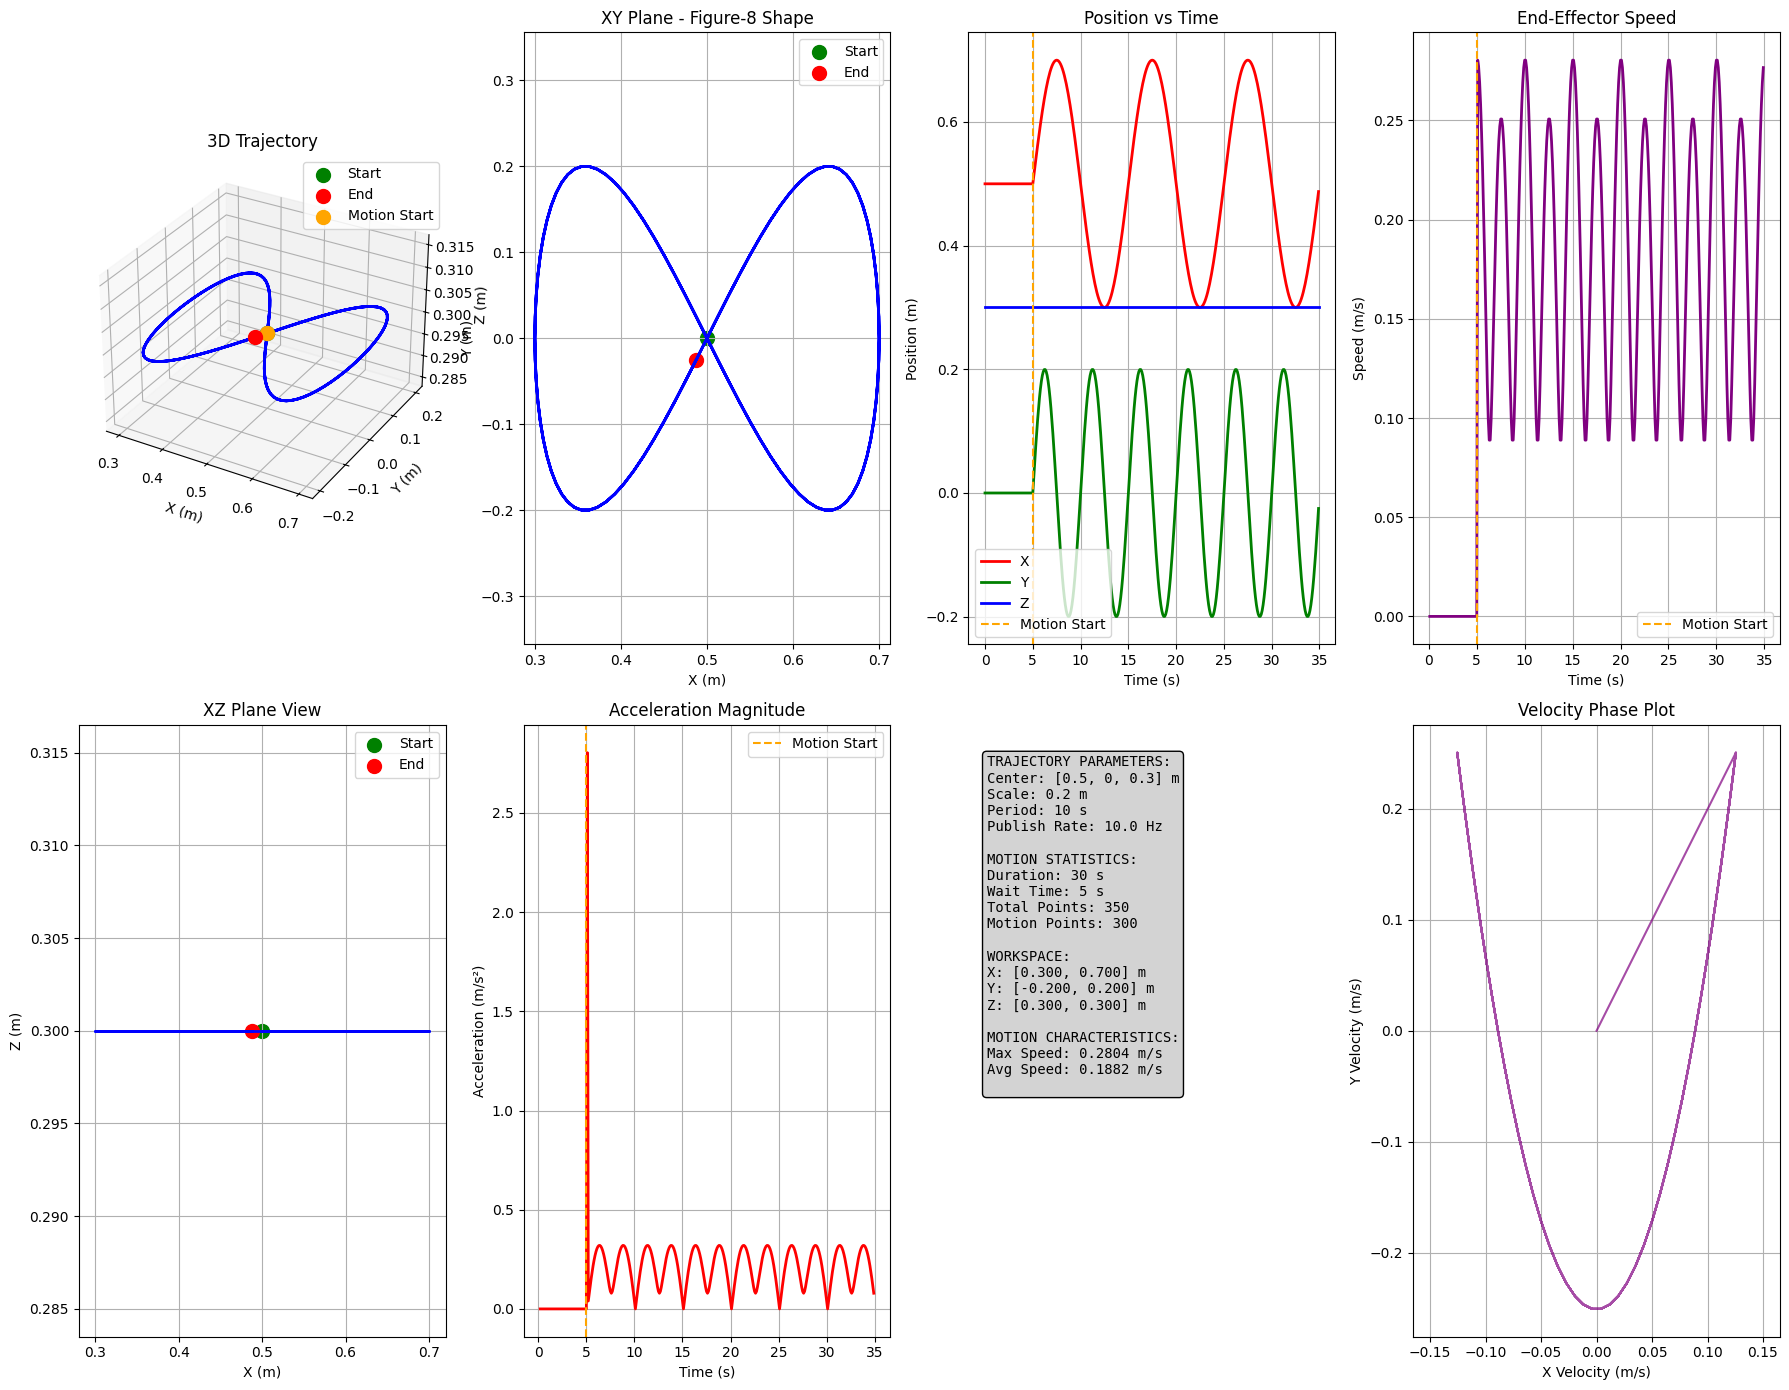

=== TRAJECTORY VISUALIZATION TOOLS ===
Available methods:
1. viz.plot_complete_analysis(duration=30) - Complete analysis
2. viz.create_animation(duration=20) - Animated trajectory
3. viz.interactive_parameter_tuning() - Interactive tuning

Example usage:
positions, times = viz.plot_complete_analysis(duration=25)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display

class TrajectoryVisualizer:
    """Visualize and analyze the figure-8 trajectory."""
    
    def __init__(self):
        # Trajectory parameters (matching your ROS script)
        self.publish_freq = 10.0  # Hz
        self.dt = 1.0 / self.publish_freq
        
    def generate_figure8_trajectory(self, t):
        """Generate figure-8 trajectory - exact copy from your ROS script."""
        # Figure-8 parameters
        center = np.array([0.5, 0, 0.3])
        scale = 0.2  # Scale factor for the figure-8 size
        period = 10  # seconds for one complete figure-8
        
        angle = 2 * np.pi * t / period
        
        x = center[0] + scale * np.sin(angle)
        y = center[1] + 2 * scale * np.sin(angle) * np.cos(angle)
        z = center[2]
        
        return np.array([x, y, z])
    
    def generate_trajectory_data(self, duration=30, include_wait=True):
        """Generate trajectory data for visualization."""
        
        # Time array
        total_time = duration + (5 if include_wait else 0)
        time_points = np.arange(0, total_time, self.dt)
        
        positions = []
        actual_times = []
        
        for i, current_time in enumerate(time_points):
            if include_wait and current_time < 5:
                # During wait period - stay at initial position
                position = self.generate_figure8_trajectory(0)
            else:
                # During trajectory execution
                traj_time = current_time - 5 if include_wait else current_time
                position = self.generate_figure8_trajectory(traj_time)
            
            positions.append(position)
            actual_times.append(current_time)
        
        return np.array(positions), np.array(actual_times)
    
    def plot_complete_analysis(self, duration=30):
        """Create comprehensive trajectory analysis."""
        
        # Generate data
        positions, times = self.generate_trajectory_data(duration, include_wait=True)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(18, 14))
        
        # 1. 3D Trajectory Plot
        ax1 = fig.add_subplot(2, 4, 1, projection='3d')
        ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=2)
        
        # Mark start and end
        ax1.scatter(positions[0, 0], positions[0, 1], positions[0, 2], 
                   c='green', s=100, label='Start')
        ax1.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], 
                   c='red', s=100, label='End')
        
        # Mark wait period end (at t=5s)
        wait_end_idx = int(5 * self.publish_freq)
        ax1.scatter(positions[wait_end_idx, 0], positions[wait_end_idx, 1], positions[wait_end_idx, 2], 
                   c='orange', s=100, label='Motion Start')
        
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_zlabel('Z (m)')
        ax1.legend()
        ax1.set_title('3D Trajectory')
        
        # 2. XY Plane View (Figure-8 shape)
        ax2 = fig.add_subplot(2, 4, 2)
        ax2.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
        ax2.scatter(positions[0, 0], positions[0, 1], c='green', s=100, label='Start')
        ax2.scatter(positions[-1, 0], positions[-1, 1], c='red', s=100, label='End')
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Y (m)')
        ax2.set_title('XY Plane - Figure-8 Shape')
        ax2.legend()
        ax2.grid(True)
        ax2.axis('equal')
        
        # 3. Position vs Time
        ax3 = fig.add_subplot(2, 4, 3)
        ax3.plot(times, positions[:, 0], 'r-', label='X', linewidth=2)
        ax3.plot(times, positions[:, 1], 'g-', label='Y', linewidth=2)
        ax3.plot(times, positions[:, 2], 'b-', label='Z', linewidth=2)
        ax3.axvline(x=5, color='orange', linestyle='--', label='Motion Start')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Position (m)')
        ax3.set_title('Position vs Time')
        ax3.legend()
        ax3.grid(True)
        
        # 4. Velocity Analysis
        ax4 = fig.add_subplot(2, 4, 4)
        velocities = np.diff(positions, axis=0) / self.dt
        speed = np.linalg.norm(velocities, axis=1)
        ax4.plot(times[1:], speed, 'purple', linewidth=2)
        ax4.axvline(x=5, color='orange', linestyle='--', label='Motion Start')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Speed (m/s)')
        ax4.set_title('End-Effector Speed')
        ax4.legend()
        ax4.grid(True)
        
        # 5. XZ Plane View
        ax5 = fig.add_subplot(2, 4, 5)
        ax5.plot(positions[:, 0], positions[:, 2], 'b-', linewidth=2)
        ax5.scatter(positions[0, 0], positions[0, 2], c='green', s=100, label='Start')
        ax5.scatter(positions[-1, 0], positions[-1, 2], c='red', s=100, label='End')
        ax5.set_xlabel('X (m)')
        ax5.set_ylabel('Z (m)')
        ax5.set_title('XZ Plane View')
        ax5.legend()
        ax5.grid(True)
        
        # 6. Acceleration Analysis
        ax6 = fig.add_subplot(2, 4, 6)
        accelerations = np.diff(velocities, axis=0) / self.dt
        acc_magnitude = np.linalg.norm(accelerations, axis=1)
        ax6.plot(times[2:], acc_magnitude, 'red', linewidth=2)
        ax6.axvline(x=5, color='orange', linestyle='--', label='Motion Start')
        ax6.set_xlabel('Time (s)')
        ax6.set_ylabel('Acceleration (m/s²)')
        ax6.set_title('Acceleration Magnitude')
        ax6.legend()
        ax6.grid(True)
        
        # 7. Trajectory Parameters
        ax7 = fig.add_subplot(2, 4, 7)
        ax7.axis('off')
        
        # Calculate statistics
        motion_start_idx = int(5 * self.publish_freq)
        motion_positions = positions[motion_start_idx:]
        motion_times = times[motion_start_idx:]
        
        if len(motion_positions) > 1:
            motion_velocities = np.diff(motion_positions, axis=0) / self.dt
            motion_speeds = np.linalg.norm(motion_velocities, axis=1)
            
            stats_text = f"""TRAJECTORY PARAMETERS:
Center: [0.5, 0, 0.3] m
Scale: 0.2 m
Period: 10 s
Publish Rate: {self.publish_freq} Hz

MOTION STATISTICS:
Duration: {duration} s
Wait Time: 5 s
Total Points: {len(positions)}
Motion Points: {len(motion_positions)}

WORKSPACE:
X: [{np.min(positions[:, 0]):.3f}, {np.max(positions[:, 0]):.3f}] m
Y: [{np.min(positions[:, 1]):.3f}, {np.max(positions[:, 1]):.3f}] m
Z: [{np.min(positions[:, 2]):.3f}, {np.max(positions[:, 2]):.3f}] m

MOTION CHARACTERISTICS:
Max Speed: {np.max(motion_speeds):.4f} m/s
Avg Speed: {np.mean(motion_speeds):.4f} m/s
"""
        else:
            stats_text = "Not enough motion data for analysis"
        
        ax7.text(0.05, 0.95, stats_text, transform=ax7.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray'))
        
        # 8. Phase Plot (X vs Y velocity)
        ax8 = fig.add_subplot(2, 4, 8)
        if len(velocities) > 0:
            ax8.plot(velocities[:, 0], velocities[:, 1], 'purple', linewidth=1.5, alpha=0.7)
            ax8.set_xlabel('X Velocity (m/s)')
            ax8.set_ylabel('Y Velocity (m/s)')
            ax8.set_title('Velocity Phase Plot')
            ax8.grid(True)
            ax8.axis('equal')
        
        plt.tight_layout()
        plt.show()
        
        return positions, times
    
    def create_animation(self, duration=20):
        """Create animated visualization of the trajectory."""
        
        positions, times = self.generate_trajectory_data(duration, include_wait=True)
        
        # Set up the figure and 3D axis
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Initialize empty line objects
        trajectory_line, = ax.plot([], [], [], 'b-', linewidth=2, alpha=0.7, label='Trajectory')
        current_point, = ax.plot([], [], [], 'ro', markersize=8, label='Current Position')
        start_point, = ax.plot([], [], [], 'go', markersize=10, label='Start')
        
        # Set axis limits
        ax.set_xlim(np.min(positions[:, 0]) - 0.05, np.max(positions[:, 0]) + 0.05)
        ax.set_ylim(np.min(positions[:, 1]) - 0.05, np.max(positions[:, 1]) + 0.05)
        ax.set_zlim(np.min(positions[:, 2]) - 0.02, np.max(positions[:, 2]) + 0.02)
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.legend()
        ax.set_title('Animated Figure-8 Trajectory')
        
        # Animation function
        def animate(frame):
            # Show trajectory up to current frame
            trajectory_line.set_data_3d(positions[:frame, 0], 
                                       positions[:frame, 1], 
                                       positions[:frame, 2])
            
            # Show current position
            if frame > 0:
                current_point.set_data_3d([positions[frame-1, 0]], 
                                        [positions[frame-1, 1]], 
                                        [positions[frame-1, 2]])
            
            # Show start position
            start_point.set_data_3d([positions[0, 0]], [positions[0, 1]], [positions[0, 2]])
            
            # Update title with current time
            ax.set_title(f'Animated Figure-8 Trajectory (t = {times[frame]:.1f}s)')
            
            return trajectory_line, current_point, start_point
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(positions), 
                           interval=100, blit=False, repeat=True)
        
        plt.show()
        return anim
    
    def interactive_parameter_tuning(self):
        """Create interactive widgets for parameter tuning."""
        
        # Create widgets
        scale_slider = widgets.FloatSlider(value=0.2, min=0.05, max=0.5, step=0.01, 
                                         description='Scale:')
        period_slider = widgets.FloatSlider(value=10.0, min=5.0, max=30.0, step=0.5, 
                                          description='Period (s):')
        center_x_slider = widgets.FloatSlider(value=0.5, min=0.2, max=0.8, step=0.01, 
                                            description='Center X:')
        center_y_slider = widgets.FloatSlider(value=0.0, min=-0.2, max=0.2, step=0.01, 
                                            description='Center Y:')
        duration_slider = widgets.FloatSlider(value=20.0, min=10.0, max=60.0, step=5.0, 
                                            description='Duration (s):')
        
        def update_plot(scale, period, center_x, center_y, duration):
            # Update trajectory function temporarily
            original_func = self.generate_figure8_trajectory
            
            def temp_trajectory(t):
                center = np.array([center_x, center_y, 0.3])
                angle = 2 * np.pi * t / period
                x = center[0] + scale * np.sin(angle)
                y = center[1] + 2 * scale * np.sin(angle) * np.cos(angle)
                z = center[2]
                return np.array([x, y, z])
            
            self.generate_figure8_trajectory = temp_trajectory
            
            # Generate and plot
            positions, times = self.generate_trajectory_data(duration, include_wait=False)
            
            plt.figure(figsize=(15, 5))
            
            # 3D plot
            ax1 = plt.subplot(1, 3, 1, projection='3d')
            ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=2)
            ax1.set_xlabel('X (m)')
            ax1.set_ylabel('Y (m)')
            ax1.set_zlabel('Z (m)')
            ax1.set_title('3D View')
            
            # XY plot
            ax2 = plt.subplot(1, 3, 2)
            ax2.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
            ax2.set_xlabel('X (m)')
            ax2.set_ylabel('Y (m)')
            ax2.set_title('Figure-8 Shape')
            ax2.axis('equal')
            ax2.grid(True)
            
            # Time series
            ax3 = plt.subplot(1, 3, 3)
            ax3.plot(times, positions[:, 0], 'r-', label='X')
            ax3.plot(times, positions[:, 1], 'g-', label='Y')
            ax3.plot(times, positions[:, 2], 'b-', label='Z')
            ax3.set_xlabel('Time (s)')
            ax3.set_ylabel('Position (m)')
            ax3.set_title('Position vs Time')
            ax3.legend()
            ax3.grid(True)
            
            plt.tight_layout()
            plt.show()
            
            # Restore original function
            self.generate_figure8_trajectory = original_func
        
        # Create interactive widget
        interactive_plot = widgets.interactive(update_plot, 
                                             scale=scale_slider,
                                             period=period_slider, 
                                             center_x=center_x_slider,
                                             center_y=center_y_slider,
                                             duration=duration_slider)
        
        display(interactive_plot)

# Create visualizer instance
viz = TrajectoryVisualizer()
# 1. Complete analysis of your current trajectory
positions, times = viz.plot_complete_analysis(duration=30)
print("=== TRAJECTORY VISUALIZATION TOOLS ===")
print("Available methods:")
print("1. viz.plot_complete_analysis(duration=30) - Complete analysis")
print("2. viz.create_animation(duration=20) - Animated trajectory")
print("3. viz.interactive_parameter_tuning() - Interactive tuning")
print("\nExample usage:")
print("positions, times = viz.plot_complete_analysis(duration=25)")